# Generating sequences by kinetic Monte-Carlo

Imports

In [1]:
import importlib
from pathlib import Path
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import pyBigWig
import logomaker

from Modules import utils, plot_utils

2023-04-05 11:59:27.453613: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def mywho():
    np.who({k: v for k, v in globals().items() if k[0]!= '_'})

Functions from MyModuleLibrary

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

# Adaptation from Etienne's predict functions for each annotation
def predict(one_hot_chr, model, annotation_type, last_window=False):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            if leftover != 0:
                pred[-leftover:] = y[-leftover:]
    return pred


Predict on random sequences

In [4]:
species = 'SCerevisiae'

In [5]:
one_hots_yeast = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots_yeast[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    one_hot_myco = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    one_hot_pneu = f['chr1']
print(one_hot_pneu.shape)

(817946, 4)


Computing kmer occurences in reference genomes

In [6]:
nucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=1, includeN=False),
     utils.kmer_counts(one_hot_myco, k=1, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=1, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
nucs

,yeast,myco,pneu
A,3797485,459397,249640
C,2354919,148404,163170
G,2358899,146831,164098
T,3784184,467567,241038


In [7]:
dinucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=2, includeN=False),
     utils.kmer_counts(one_hot_myco, k=2, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=2, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
dinucs

yeast    myco   pneu
A A  1328434  198698  98619
  C   650916   49220  50860
  G   720466   59338  48030
  T  1097616  152141  52131
C A   799225   62471  53154
  C   478979   18985  36740
  G   361794    6460  26768
  T   714897   60488  46508
G A   769308   55940  40971
  C   461044   22661  37190
  G   479363   18352  36868
  T   649134   49877  49068
T A   900468  142288  56896
  C   763937   57537  38379
  G   797248   62681  52432
  T  1322466  205061  93331

In [ ]:
trinucs = pd.concat(
    [utils.kmer_counts(one_hots_yeast, k=3, includeN=False),
     utils.kmer_counts(one_hot_myco, k=3, includeN=False),
     utils.kmer_counts(one_hot_pneu, k=3, includeN=False)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
trinucs

Convert to frequencies and compare with expected frequencies with specific gc

In [8]:
freqs_ref = dinucs / dinucs.sum(axis=0)
for col in nucs.columns:
    freqs_ref[f'rand_nuc_{col}'] = utils.ref_kmer_frequencies(nucs[col], k=2)
freqs_ref

yeast      myco      pneu  rand_nuc_yeast  rand_nuc_myco  \
A A  0.108044  0.162574  0.120569        0.095390       0.141284   
  C  0.052940  0.040272  0.062180        0.059154       0.045640   
  G  0.058597  0.048550  0.058720        0.059253       0.045157   
  T  0.089271  0.124481  0.063734        0.095055       0.143796   
C A  0.065003  0.051114  0.064985        0.059154       0.045640   
  C  0.038956  0.015533  0.044917        0.036683       0.014744   
  G  0.029425  0.005286  0.032726        0.036745       0.014587   
  T  0.058144  0.049491  0.056860        0.058946       0.046452   
G A  0.062569  0.045770  0.050090        0.059253       0.045157   
  C  0.037498  0.018541  0.045468        0.036745       0.014587   
  G  0.038988  0.015016  0.045074        0.036807       0.014433   
  T  0.052795  0.040809  0.059989        0.059046       0.045960   
T A  0.073237  0.116420  0.069560        0.095055       0.143796   
  C  0.062132  0.047077  0.046921        0.058946       0.046452   
  G  0.064842  0.051285  0.064102        0.059046       0.045960   
  T  0.107559  0.167781  0.114104        0.094722       0.146354   

     rand_nuc_pneu  
A A       0.093149  
  C       0.060884  
  G       0.061231  
  T       0.089939  
C A       0.060884  
  C       0.039795  
  G       0.040022  
  T       0.058786  
G A       0.061231  
  C       0.040022  
  G       0.040249  
  T       0.059121  
T A       0.089939  
  C       0.058786  
  G       0.059121  
  T       0.086840

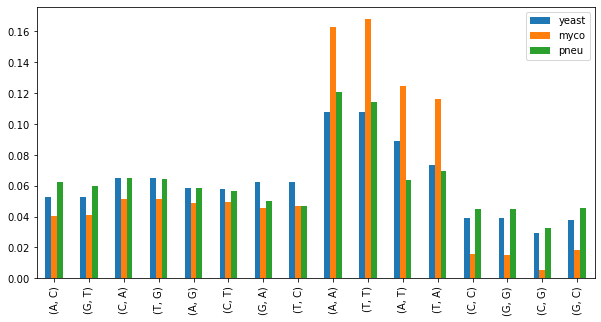

In [9]:
plot_utils.plot_2mer_df(freqs_ref, columns=['yeast', 'myco', 'pneu'])

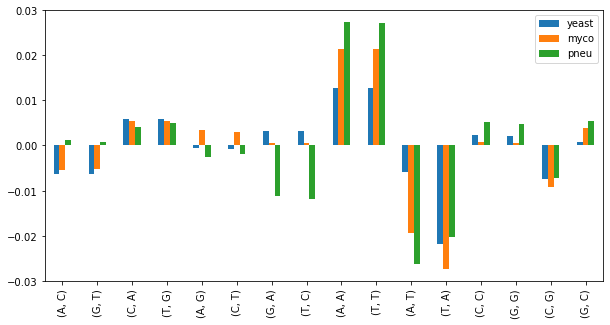

In [10]:
freqs_diff = freqs_ref.loc[:, 'yeast':'pneu'] - freqs_ref.loc[:, 'rand_nuc_yeast':'rand_nuc_pneu'].rename({freqs_ref.columns[i+3]: freqs_ref.columns[i] for i in range(3)}, axis=1)
plot_utils.plot_2mer_df(freqs_diff, columns=['yeast', 'myco', 'pneu'])

Generate sequences with specific kmer frequencies and test it

In [ ]:
n_seqs = 32
seq_length = 32768
reference = 'myco'
seqs = utils.random_sequences(n_seqs, seq_length, nucs.loc[:, reference], dinucs.loc[:, reference])
freqs = utils.kmer_counts(utils.one_hot_encoding(seqs, seq_length), k=2, includeN=False)
freqs /= freqs.sum()
freqs

In [ ]:
freqs_ref.loc[:, 'myco'] - freqs

In [131]:
# Generate genomes with same length and content as yeast
one_hots = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots[chr_id] = utils.random_shuffles(f[chr_id], 1)[0]
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz'), **one_hots)

In [32]:
# Predict on genomes with same length and content as yeast
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
elif annotation_type == 'cohesine':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
    custom_objects = {'correlate' : correlate}
elif annotation_type == 'pol':
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                    Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
    custom_objects = {'correlate' : correlate}
else:
    raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

one_hots = {}
preds = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
    for chr_id in f.keys():
        one_hots[chr_id] = f[chr_id]
        preds[chr_id] = np.empty((len(one_hots[chr_id]), 3), dtype='float32')

for model_idx, model_file in enumerate(model_files):
    print('model', model_idx)
    for chr_id, one_hot in one_hots.items():
        model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
        preds[chr_id][:, model_idx] = predict(one_hot, model, annotation_type)
    del model
np.who(preds)
np.savez(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_on_random_genome_as_yeast1.npz'),
         **preds)


model 0
model 1
model 2
Name            Shape             Bytes            Type

chr01           252221 x 3        3026652          float32
chr02           844051 x 3        10128612         float32
chr03           341087 x 3        4093044          float32
chr04           1575129 x 3       18901548         float32
chr05           572496 x 3        6869952          float32
chr06           277781 x 3        3333372          float32
chr07           1092105 x 3       13105260         float32
chr08           564939 x 3        6779268          float32
chr09           430780 x 3        5169360          float32
chr10           762303 x 3        9147636          float32
chr11           683383 x 3        8200596          float32
chr12           1084257 x 3       13011084         float32
chr13           929095 x 3        11149140         float32
chr14           793416 x 3        9520992          float32
chr15           1108329 x 3       13299948         float32
chr16           986200 x 3        

In [15]:
# Generate sequences with similar 2mer distributions
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 1000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

refs = ['yeast', 'myco', 'pneu']
seqs = []
for ref in refs:
    seqs.append(utils.random_sequences(n_seqs, WINDOW, nucs.loc[:, ref], dinucs.loc[:, ref]))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(len(refs), -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_2mer_as_refs_indep_{n_seqs}.npy'), preds)

In [37]:
# Generate independent windows for different gc
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 10000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
seqs = []
for gc in gcs:
    seqs.append(utils.random_seq_strict_GC(n_seqs, WINDOW, gc))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), one_hots)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(n_gcs, -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_strictGCrange_indep_{n_seqs}.npy'), preds)

2023-04-03 14:17:55.691914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.
2023-04-03 14:18:08.338724: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.
2023-04-03 14:18:20.933234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13446720000 exceeds 10% of free system memory.


In [84]:
# Generate a sequence and change to ployA in the middle
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    n_windows = 10_000
    WINDOW = 2001
    model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
    order = 'ATGC'
    buffer = WINDOW // 2
    seq_length = buffer*2 + n_windows
else:
    if annotation_type == 'cohesine':
        WINDOW = 32768
        n_windows = 10
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5')
    elif annotation_type == 'pol':
        WINDOW = 2048
        n_windows = 100
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5')
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
    order = 'ACGT'
    buffer = 0
    seq_length = WINDOW * n_windows

n_seqs = 100
n_As = 6
seq_length = 2001*2 + n_As - 2
n_gcs = 1 # 21
gcs = [0.38] # np.linspace(0, 1, n_gcs)
preds = []
preds_save = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seqs = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=p)
    seqs_save = seqs.copy()
    seqs[:, seq_length//2 - n_As//2 : seq_length//2 + n_As//2] = 'A'
    one_hots_save = utils.one_hot_encoding(seqs_save, read_length=seq_length, one_hot_type=int, order=order)
    one_hots = utils.one_hot_encoding(seqs, read_length=seq_length, one_hot_type=int, order=order)
    for one_hot in one_hots:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds.append(pred[buffer:len(pred)-buffer])
    for one_hot in one_hots_save:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds_save.append(pred[buffer:len(pred)-buffer])
del model
preds = np.array(preds)
preds_save = np.array(preds_save)
print(preds.shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_with{n_As}As.npy'), preds)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_without{n_As}As.npy'), preds_save)

(100, 2006)


Load predictions on random sequences

In [248]:
WINDOW = 2001
one_hots = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'seqs_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
one_hots = one_hots.reshape(21, -1, WINDOW, 4)
preds = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds = preds.reshape(21, 3, -1)
one_hots.shape, preds.shape

((21, 10000, 2001, 4), (21, 3, 10000))

In [253]:
gc_eff = utils.GC_content(one_hots[8], order='ATGC')
len(np.unique(gc_eff))

1

1000 1000


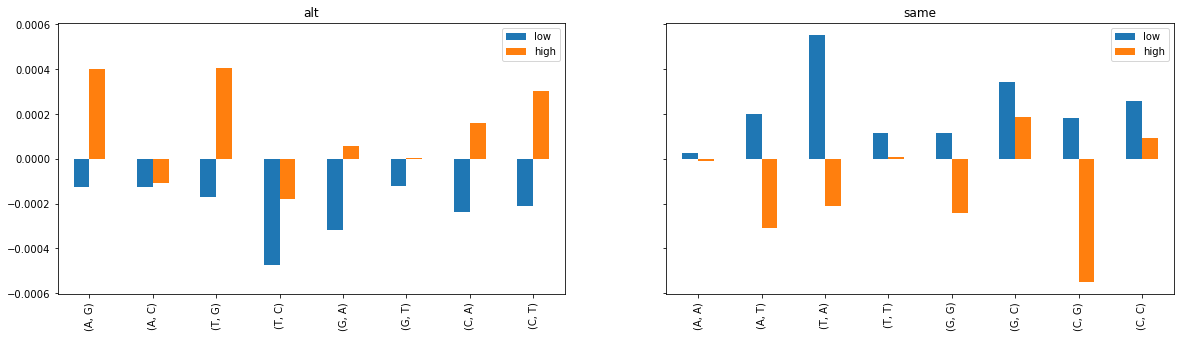

In [83]:
gc_idx = 8
preds_gc = preds.mean(axis=1)[gc_idx]
q10, q45, q55, q90 = np.quantile(preds_gc, [0.1, 0.45, 0.55, 0.9])
low_idx = np.where(preds_gc < q10)[0]
lows = one_hots[gc_idx, low_idx]
mid_idx = np.where((q45 < preds_gc) & (preds_gc < q55))[0]
mids = one_hots[gc_idx, mid_idx]
high_idx = np.where(preds_gc > q90)[0]
highs = one_hots[gc_idx, high_idx]
print(len(low_idx), len(mid_idx), len(high_idx))

df = pd.concat({
    'low': utils.kmer_counts(lows, k=2, order='ATGC', includeN=False),
    'mid': utils.kmer_counts(mids, k=2, order='ATGC', includeN=False),
    'high': utils.kmer_counts(highs, k=2, order='ATGC', includeN=False),
    }, axis=1)
df /= df.sum(axis=0)
diffs = df - df['mid'].values[:, None]
diffs['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(diffs.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', y=['low', 'high'], ax=ax, title=key)

In [120]:
start_idx = 4
stop_idx = 11
preds_gc = preds[start_idx:stop_idx, 0]
q50 = np.quantile(preds_gc, 0.5, axis=1, keepdims=True)
low_gc_idx, low_pred_idx = (preds_gc < q50).nonzero()
lows = one_hots[start_idx + low_gc_idx, low_pred_idx].reshape(stop_idx - start_idx, -1, WINDOW, 4)
high_gc_idx, high_pred_idx = (preds_gc > q50).nonzero()
highs = one_hots[start_idx + high_gc_idx, high_pred_idx].reshape(stop_idx - start_idx, -1, WINDOW, 4)
print(highs.shape)
df_dict = {}
for i in range(stop_idx-start_idx):
    serh = utils.kmer_counts(highs[i], k=2, order='ATGC', includeN=False)
    serh /= serh.sum(axis=0)
    serl = utils.kmer_counts(lows[i], k=2, order='ATGC', includeN=False)
    serl /= serl.sum(axis=0)
    df_dict[f'gc{round(0.05*(start_idx + i), 2)}'] = serh -serl
df = pd.concat(df_dict, axis=1)
df['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2
df

(7, 5000, 2001, 4)


gc0.2    gc0.25         gc0.3    gc0.35     gc0.4    gc0.45     gc0.5  \
A A  0.000033  0.000105  7.710000e-05  0.000111  0.000148 -0.000263 -0.000285   
  T -0.000168 -0.000174 -3.824000e-04 -0.000248 -0.000410 -0.000142 -0.000129   
  G -0.000019  0.000051  1.764000e-04  0.000131  0.000124  0.000324  0.000277   
  C  0.000161  0.000014  1.282000e-04  0.000006  0.000137  0.000080  0.000134   
T A -0.000282 -0.000013 -1.820000e-04 -0.000413 -0.000251 -0.000054 -0.000085   
  T  0.000155 -0.000064  1.545000e-04 -0.000014  0.000033 -0.000150 -0.000144   
  G  0.000128  0.000080  8.340000e-05  0.000241  0.000215  0.000133  0.000239   
  C -0.000008 -0.000001 -5.330000e-05  0.000187 -0.000004  0.000071  0.000004   
G A -0.000016 -0.000057 -1.000000e-07  0.000256  0.000010  0.000224  0.000169   
  T  0.000057  0.000158  8.010000e-05  0.000021  0.000106 -0.000022  0.000054   
  G -0.000023 -0.000066 -1.906000e-04 -0.000195 -0.000081 -0.000158 -0.000142   
  C -0.000020 -0.000037  1.094000e-04 -0.000081 -0.000035 -0.000045 -0.000092   
C A  0.000264 -0.000037  9.600000e-05  0.000046  0.000091  0.000091  0.000201   
  T -0.000045  0.000075  1.480000e-04  0.000242  0.000279  0.000313  0.000209   
  G -0.000084 -0.000061 -6.770000e-05 -0.000176 -0.000259 -0.000298 -0.000367   
  C -0.000132  0.000027 -1.770000e-04 -0.000113 -0.000105 -0.000103 -0.000043   

    nextgc  
A A   same  
  T   same  
  G    alt  
  C    alt  
T A   same  
  T   same  
  G    alt  
  C    alt  
G A    alt  
  T    alt  
  G   same  
  C   same  
C A    alt  
  T    alt  
  G   same  
  C   same

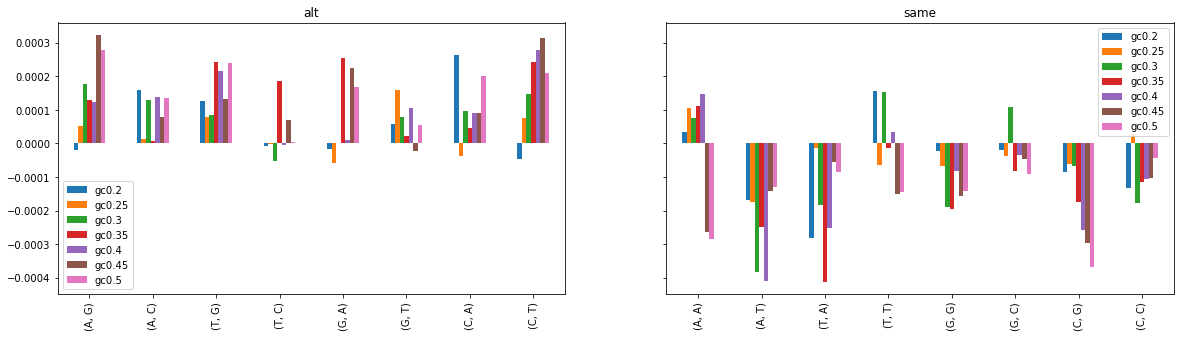

In [121]:
fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(df.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', ax=ax, title=key)

5000 5000


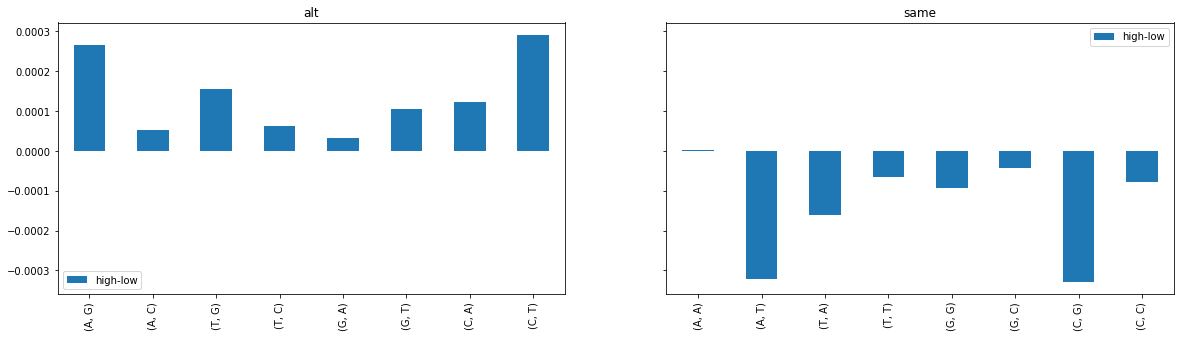

In [254]:
gc_idx = 8
preds_gc = preds.mean(axis=1)[gc_idx]
q50 = np.quantile(preds_gc, 0.5)
low_idx = np.where(preds_gc < q50)[0]
lows = one_hots[gc_idx, low_idx]
high_idx = np.where(preds_gc > q50)[0]
highs = one_hots[gc_idx, high_idx]
print(len(low_idx), len(high_idx))

df = pd.concat({
    'low': utils.kmer_counts(lows, k=2, order='ATGC', includeN=False),
    'high': utils.kmer_counts(highs, k=2, order='ATGC', includeN=False),
    }, axis=1)
df /= df.sum(axis=0)
df['high-low'] = df.loc[:, 'high'] - df.loc[:, 'low']
df['nextgc'] = ['same', 'same', 'alt', 'alt']*2 + ['alt', 'alt', 'same', 'same']*2

fig, axes = plt.subplots(1, 2, sharey='row', figsize=(20, 5), facecolor='w')
for (key, grp), ax in zip(df.groupby('nextgc'), axes.flatten()):
    grp.plot(kind='bar', y=['high-low'], ax=ax, title=key)

In [256]:
df1 = pd.concat({
    'lows': utils.kmer_counts(lows, k=1, order='ATGC', includeN=False),
    # 'mids': utils.kmer_counts(mids, k=1, order='ATGC', includeN=False),
    'highs': utils.kmer_counts(highs, k=1, order='ATGC', includeN=False),
    }, axis=1)
df1

,lows,highs
A,3005000,3005000
T,3000000,3000000
G,2000000,2000000
C,2000000,2000000


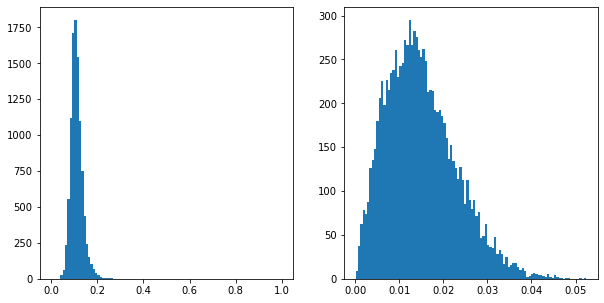

In [72]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(preds.mean(axis=1)[gc_idx], bins=100, range=(0, 1))
plt.subplot(122)
plt.hist(preds.std(axis=1)[gc_idx], bins=100)
plt.show()
plt.close()

Making plot for Romain with predictions on random sequences, labels and predictions

In [188]:
preds_nuc_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_2mer_as_refs_indep_1000.npy'))
preds_coh_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_2mer_as_refs_indep_32.npy'))
preds_pol_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_2mer_as_refs_indep_32.npy'))
preds_nuc_rand_sim.shape, preds_coh_rand_sim.shape, preds_pol_rand_sim.shape

((3, 3000), (3, 24576), (3, 1536))

In [189]:
# Random preds for original plot
preds_nuc_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_randomGC_indep_10000.npy'))
preds_coh_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_randomGC_indep_32.npy'))
preds_pol_rand2 = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_randomGC_indep_32.npy'))

preds_nuc_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_random_strictGCrange_indep_10000.npy'))
preds_coh_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_random_strictGCrange_indep_32.npy'))
preds_pol_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_random_strictGCrange_indep_32.npy'))
preds_nuc_rand.shape, preds_coh_rand.shape, preds_pol_rand.shape

((21, 30000), (21, 24576), (21, 1536))

### Load and normalize labels

Load nucleosome labels

In [257]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    # My preferred way to deal with inf
    x_[np.isinf(x_)] = np.max(x_[np.isfinite(x_)])
    # Workaround Etienne's way to avoid inf in cohesine myco
    # x_[np.isinf(x_)] = np.percentile(x_, 98)
    # Etienne's way
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

def load_yeast_bw(filename, bact='myco', romantoint=False, process=None):
    # Load bigwig
    labels = utils.load_bw(filename)
    # Change chromosome names
    if romantoint:
        for key in list(labels.keys()):
            if key[:3] == 'chr':
                new_key = 'chr' + format(utils.roman_to_int(key[3:]), '02d')
                labels[new_key] = labels.pop(key)
    if bact == 'myco':
        chr_id = list({'Mmm_Linear_740kb.fa', 'Mmmyco'}.intersection(labels.keys()))
        assert len(chr_id) == 1
        labels['myco'] = labels.pop(chr_id[0])
    elif bact == 'pneu':
        labels['pneu'] = labels.pop('Pneu300')
    # Remove unwanted chromosomes
    for key in list(labels.keys()):
        if key[:3] != 'chr' and key != bact:
            labels.pop(key)
    # Transform data
    if process is not None:
        if process == 'conv':
            process = lambda x: utils.moving_average(x, 21, keepsize=True)
        elif process == 'log':
            process = lambda x: np.log2(1 + x)
        for key, value in labels.items():
            labels[key] = process(value)
    # Normalize in CPM
    thres = sum(v.sum() for v in labels.values()) / 1e6
    for key, value in labels.items():
        labels[key] = value / thres
    return labels

def load_yeast_nuc(mycofile=None, pneufile=None, asdict=True, priority='myco', process='conv'):
    if mycofile is None:
        mycofile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw'
    if pneufile is None:
        pneufile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw'
    # Load bigwigs
    labels_myco = load_yeast_bw(mycofile, bact='myco', process=process)
    labels_pneu = load_yeast_bw(pneufile, bact='pneu', process=process)
    # Get labels from priority file
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value
        labels['pneu'] = labels_pneu['pneu']
    else:
        for key, value in labels_pneu.items():
            labels[key] = value
        labels['myco'] = labels_myco['myco']
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                    asdict=True, priority='myco'):
    # Get log ratios
    labels_myco = {}
    for key, value in labels_ipmyco.items():
        labels_myco[key] = log(value / labels_ctrlmyco[key])
    thres_myco = sum(v.sum() for v in labels_myco.values()) / 1e6
    labels_pneu = {}
    for key, value in labels_ippneu.items():
        labels_pneu[key] = log(value / labels_ctrlpneu[key])
    thres_pneu = sum(v.sum() for v in labels_pneu.values()) / 1e6
    # Get labels from priority file, and normalize in CPM
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value / thres_myco
        labels['pneu'] = labels_pneu['pneu'] / thres_pneu
    else:
        for key, value in labels_pneu.items():
            labels[key] = value / thres_pneu
        labels['myco'] = labels_myco['myco'] / thres_myco
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_coh(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='pneu'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco', romantoint=True)
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco', romantoint=True)
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

def load_yeast_pol(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='myco'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco')
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco')
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

# labels_nuc_yeast, labels_nuc_myco, labels_nuc_pneu = load_yeast_nuc(asdict=False, process=None)
# labels_coh_yeast, labels_coh_myco, labels_coh_pneu = load_yeast_coh(asdict=False)
# labels_pol_yeast, labels_pol_myco, labels_pol_pneu = load_yeast_pol(asdict=False)
labels_nuc = load_yeast_nuc()
labels_coh = load_yeast_coh()
labels_pol = load_yeast_pol()

/tmp/ipykernel_861130/180740096.py:80: RuntimeWarning: divide by zero encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_861130/180740096.py:80: RuntimeWarning: invalid value encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_861130/180740096.py:84: RuntimeWarning: divide by zero encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])
/tmp/ipykernel_861130/180740096.py:84: RuntimeWarning: invalid value encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])


Compute GC content

In [184]:
species = 'SCerevisiae'
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    gc_yeast = utils.GC_content(np.concatenate(([v for k, v in f.items() if k[:3]=='chr'])).reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    gc_myco = utils.GC_content(f['chr1'].reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    gc_pneu = utils.GC_content(f['chr1'].reshape(1, -1, 4))
print(gc_yeast, gc_myco, gc_pneu)

[0.3833779] [0.2415605] [0.40010954]


Load predictions of first model

In [193]:
preds_nuc = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']
thres_pred_nm = sum([np.sum(v) for k, v in preds_nuc.items() if k!='pneu']) / 1e6
print(thres_pred_nm)

preds_nuc2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Pneu300.npz')) as f:
    preds_nuc2['pneu'] = f['chr1']
thres_pred2_nm = sum([np.sum(v) for k, v in preds_nuc2.items() if k!='pneu']) / 1e6
print(thres_pred2_nm)

preds_nuc3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Pneu300.npz')) as f:
    preds_nuc3['pneu'] = f['chr1']
thres_pred3_nm = sum([np.sum(v) for k, v in preds_nuc3.items() if k!='pneu']) / 1e6
print(thres_pred3_nm)

2.4999501792400705
2.4288635174474864
2.511639808070898


In [194]:
preds_coh = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300.npz')) as f:
    preds_coh['pneu'] = f['chr1']
thres_pred_cm = sum([np.sum(v) for k, v in preds_coh.items() if k!='pneu']) / 1e6
print(thres_pred_cm)

preds_coh2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Pneu300.npz')) as f:
    preds_coh2['pneu'] = f['chr1']
thres_pred2_cm = sum([np.sum(v) for k, v in preds_coh2.items() if k!='pneu']) / 1e6
print(thres_pred2_cm)

preds_coh3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Pneu300.npz')) as f:
    preds_coh3['pneu'] = f['chr1']
thres_pred3_cm = sum([np.sum(v) for k, v in preds_coh3.items() if k!='pneu']) / 1e6
print(thres_pred3_cm)

14.900761329948425
13.782405389259338
14.714640640129089


In [195]:
preds_pol = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Pneu300.npz')) as f:
    preds_pol['pneu'] = f['chr1']
thres_pred_pm = sum([np.sum(v) for k, v in preds_pol.items() if k!='pneu']) / 1e6
print(thres_pred_pm)

preds_pol2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Pneu300.npz')) as f:
    preds_pol2['pneu'] = f['chr1']
thres_pred2_pm = sum([np.sum(v) for k, v in preds_pol2.items() if k!='pneu']) / 1e6
print(thres_pred2_pm)

preds_pol3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Pneu300.npz')) as f:
    preds_pol3['pneu'] = f['chr1']
thres_pred3_pm = sum([np.sum(v) for k, v in preds_pol3.items() if k!='pneu']) / 1e6
print(thres_pred3_pm)

7.687648562885284
9.267423528263093
9.620498055236816


Plot predictions vs GC content on random and true sequences

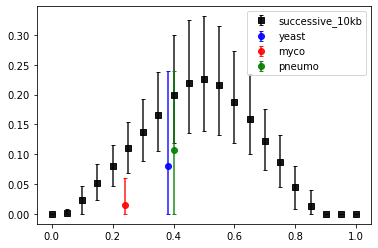

In [17]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
# plt.errorbar(gcs, y=preds.mean(axis=1), yerr=np.quantile(preds, [q_min, q_max], axis=1), fmt='ys', alpha=0.9, label='successive', capsize=2)
mean_nuc = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc, yerr=np.abs(mean_nuc - np.quantile(preds_nuc_rand, [q_min, q_max], axis=1)), fmt='ks', alpha=0.9, label='successive_10kb', capsize=2)
# plt.errorbar(gcs, y=preds_indep.mean(axis=1), yerr=np.quantile(preds_indep, [q_min, q_max], axis=1), fmt='ys', alpha=0.9, label='independent')
mean_yeast = norm_yeast.mean()
mean_myco = norm_myco.mean()
mean_pneu = norm_pneu.mean()
plt.errorbar(gc_yeast, y=[mean_yeast], yerr=np.abs(mean_yeast - np.quantile(norm_yeast, [q_min, q_max])).reshape(2, 1), fmt='bo', alpha=0.9, label='yeast', capsize=2)
plt.errorbar(gc_myco, y=[mean_myco], yerr=np.abs(mean_myco - np.quantile(norm_myco, [q_min, q_max])).reshape(2, 1), fmt='ro', alpha=0.9, label='myco', capsize=2)
plt.errorbar(gc_pneu, y=[mean_pneu], yerr=np.abs(mean_pneu - np.quantile(norm_pneu, [q_min, q_max])).reshape(2, 1), fmt='go', alpha=0.9, label='pneumo', capsize=2)
plt.legend()

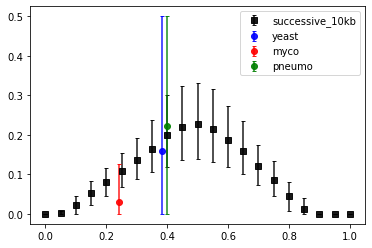

In [19]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
mean_nuc = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc, yerr=np.abs(mean_nuc - np.quantile(preds_nuc_rand, [q_min, q_max], axis=1)), fmt='ks', alpha=0.9, label='successive_10kb', capsize=2)
mean_yeast = clip_yeast.mean()
mean_myco = clip_myco.mean()
mean_pneu = clip_pneu.mean()
plt.errorbar(gc_yeast, y=[mean_yeast], yerr=np.abs(mean_yeast - np.quantile(clip_yeast, [q_min, q_max])).reshape(2, 1), fmt='bo', alpha=0.9, label='yeast', capsize=2)
plt.errorbar(gc_myco, y=[mean_myco], yerr=np.abs(mean_myco - np.quantile(clip_myco, [q_min, q_max])).reshape(2, 1), fmt='ro', alpha=0.9, label='myco', capsize=2)
plt.errorbar(gc_pneu, y=[mean_pneu], yerr=np.abs(mean_pneu - np.quantile(clip_pneu, [q_min, q_max])).reshape(2, 1), fmt='go', alpha=0.9, label='pneumo', capsize=2)
plt.legend()

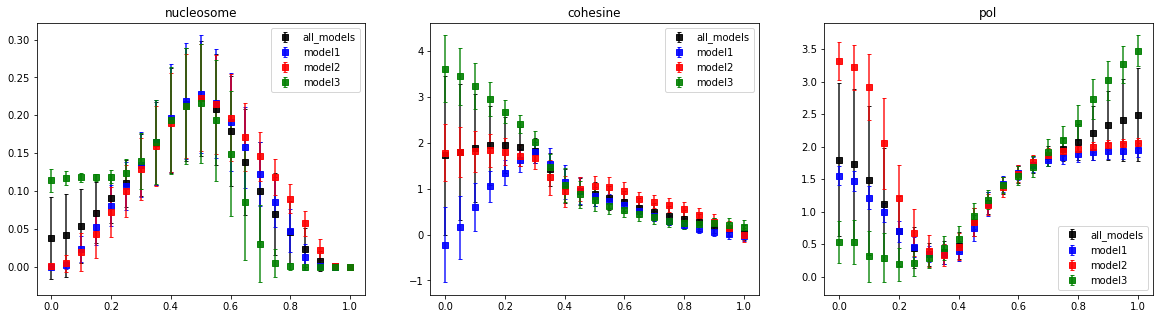

In [196]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
mean_nuc_rand = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc_rand, yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_nuc_rand[:, i], yerr=stds_nuc_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
mean_coh_rand = preds_coh_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_coh_rand, yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
# plt.errorbar(gcs, y=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].mean(axis=(1, 2)), yerr=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].std(axis=(1, 2)), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_coh_rand[:, i], yerr=stds_coh_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
mean_pol_rand = preds_pol_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_pol_rand, yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_pol_rand[:, i], yerr=stds_pol_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

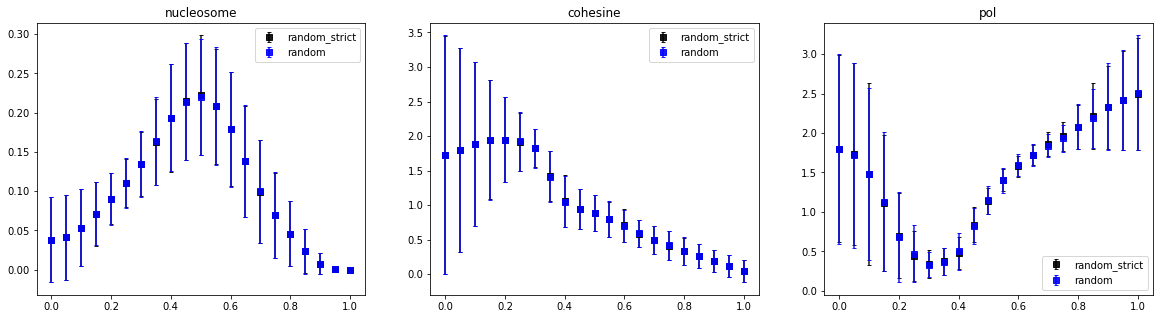

In [197]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
plt.errorbar(gcs, y=preds_nuc_rand.mean(axis=1), yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_nuc_rand2.mean(axis=1), yerr=preds_nuc_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
plt.errorbar(gcs, y=preds_coh_rand.mean(axis=1), yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_coh_rand2.mean(axis=1), yerr=preds_coh_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
plt.errorbar(gcs, y=preds_pol_rand.mean(axis=1), yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='random_strict', capsize=2)
plt.errorbar(gcs, y=preds_pol_rand2.mean(axis=1), yerr=preds_pol_rand2.std(axis=1), fmt='bs', alpha=0.9, label='random', capsize=2)
plt.legend()

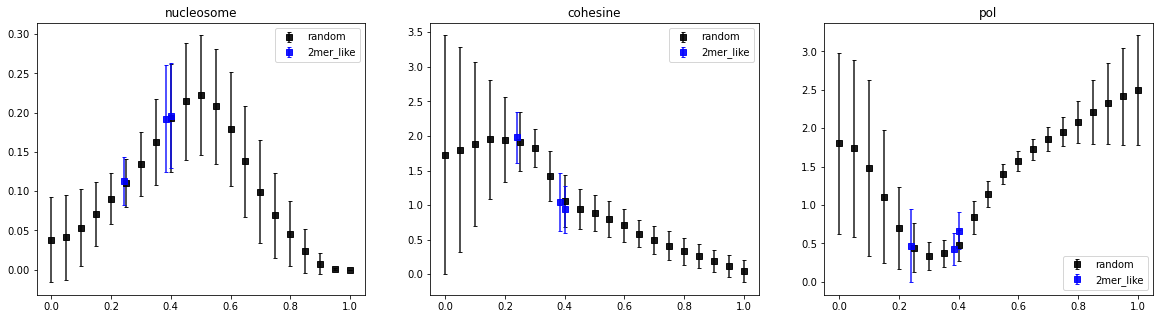

In [198]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
plt.errorbar(gcs, y=preds_nuc_rand.mean(axis=1), yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_nuc_rand_sim.mean(axis=1), yerr=preds_nuc_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
plt.errorbar(gcs, y=preds_coh_rand.mean(axis=1), yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_coh_rand_sim.mean(axis=1), yerr=preds_coh_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
plt.errorbar(gcs, y=preds_pol_rand.mean(axis=1), yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_pol_rand_sim.mean(axis=1), yerr=preds_pol_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

Compute sliding GC content on all windows

In [49]:
window_gc_full = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc_full[chr_id] = utils.sliding_GC(f[chr_id], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc_full['myco'] = utils.sliding_GC(f['chr1'], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc_full['pneu'] = utils.sliding_GC(f['chr1'], 2000)

In [258]:
window_gc = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc[chr_id] = utils.GC_content(utils.chunk_regions(f[chr_id],  2000))
window_gc_yeast = np.concatenate([v for k, v in window_gc.items() if k[:3]=='chr'])

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc['myco'] = utils.GC_content(utils.chunk_regions(f['chr1'],  2000))

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc['pneu'] = utils.GC_content(utils.chunk_regions(f['chr1'],  2000))

In [266]:
window_gc_r = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
    for chr_id in f.keys():
        window_gc_r[chr_id] = utils.GC_content(utils.chunk_regions(f[chr_id],  2000))
window_gc_rand = np.concatenate(list(window_gc_r.values()))

In [261]:
window_labels = {}
for key in labels_nuc.keys():
    window_labels[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (labels_nuc[key], labels_coh[key], labels_pol[key])],
                axis=1),
            2000),
        axis=1)
window_labels_yeast = np.concatenate([v for k, v in window_labels.items() if k[:3]=='chr'])

In [260]:
window_preds = {}
for key in preds_nuc.keys():
    window_preds[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (preds_nuc[key] / thres_pred_nm, preds_coh[key] / thres_pred_cm, preds_pol[key] / thres_pred_pm)],
                axis=1),
            2000),
        axis=1)
window_preds_yeast = np.concatenate([v for k, v in window_preds.items() if k[:3]=='chr'])

Concatenate yeast chromosomes

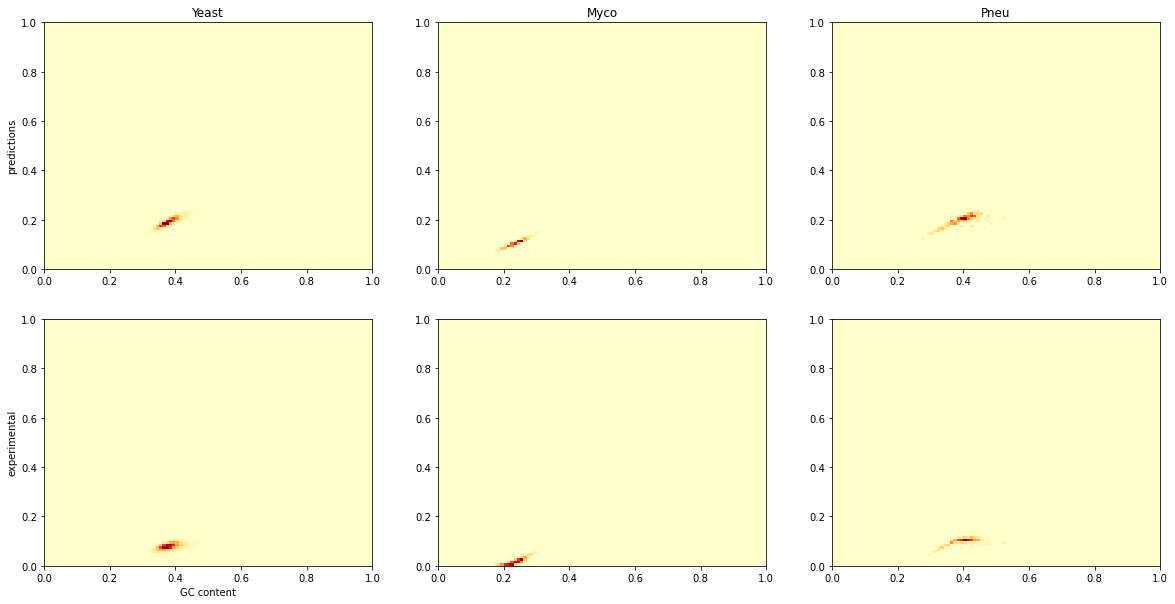

In [133]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(231)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, window_preds_yeast[:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax2 = plt.subplot(232)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], window_preds['myco'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax3 = plt.subplot(233)
ax3.set_title('Pneu')
ax3.hist2d(window_gc['pneu'], window_preds['pneu'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax4 = plt.subplot(234)
ax4.hist2d(window_gc_yeast, window_labels_yeast[:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax5 = plt.subplot(235)
ax5.hist2d(window_gc['myco'], window_labels['myco'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax6 = plt.subplot(236)
ax6.hist2d(window_gc['pneu'], window_labels['pneu'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax4.set_ylabel('experimental')
ax4.set_xlabel('GC content')
plt.show()
plt.close()

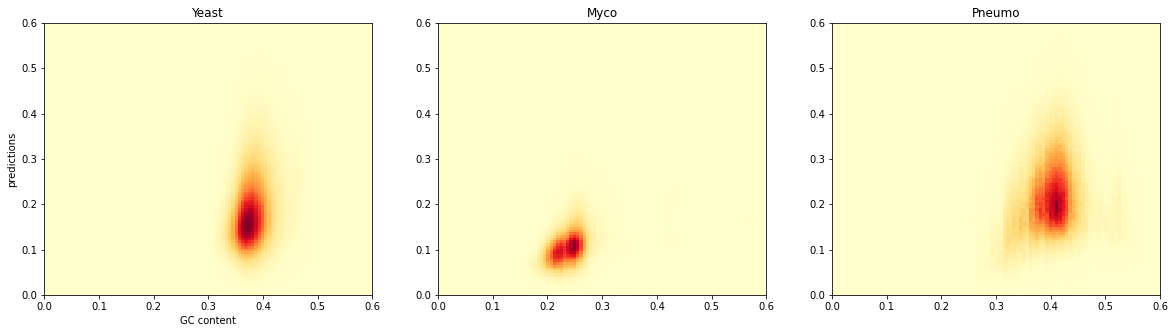

In [137]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(131)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax2 = plt.subplot(132)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax3 = plt.subplot(133)
ax3.set_title('Pneumo')
ax3.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax.set_xlabel('GC content')
plt.show()
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


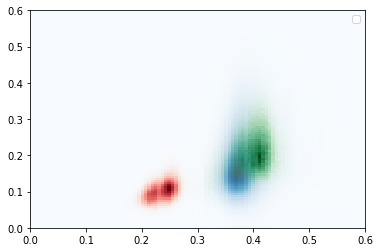

In [140]:
red = plt.cm.Reds
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = mpl.colors.ListedColormap(fading_red)
green = plt.cm.Greens
fading_green = green(np.arange(green.N)) # extract colors
fading_green[:, -1] = np.linspace(0, 1, green.N) # modify alpha
fading_green = mpl.colors.ListedColormap(fading_green)
plt.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='Blues', label='yeast')
plt.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_red, label='myco')
plt.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_green, label='pneumo')
plt.legend()
plt.show()
plt.close()

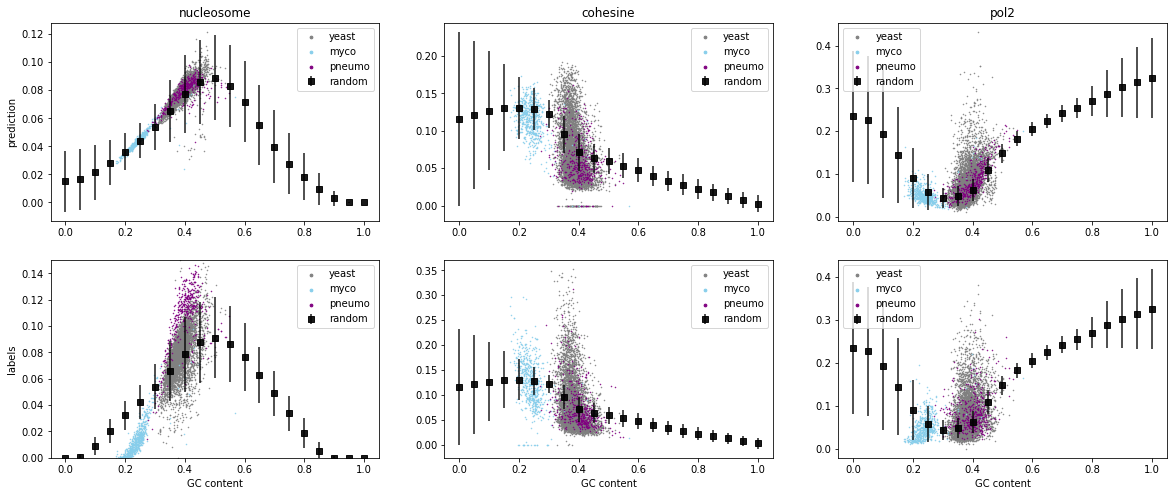

In [263]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 8))
titles = ['nucleosome', 'cohesine', 'pol2']
s = 1
s_yeast = 1
for i in range(3):
    plt.subplot(231+i)
    plt.title(titles[i])
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand / thres_pred_nm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_preds_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_preds['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_preds['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('prediction')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
for i in range(3):
    plt.subplot(234+i)
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).mean(axis=2)[:, 0], yerr=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).std(axis=2)[:, 0], fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        # plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_labels_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_labels['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_labels['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('labels')
        plt.ylim((0, 0.15))
    plt.xlabel('GC content')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
plt.show()
plt.close()


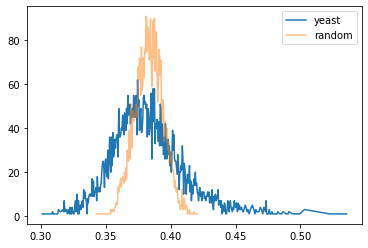

In [272]:
gcs, counts = np.unique(window_gc_yeast, return_counts=True)
gcs_r, counts_r = np.unique(window_gc_rand, return_counts=True)
plt.plot(gcs, counts, label='yeast')
plt.plot(gcs_r, counts_r, alpha=0.5, label='random')
plt.legend()
plt.show()
plt.close()

(0.0, 0.2)

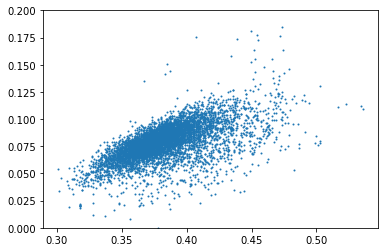

In [268]:
plt.scatter(window_gc_yeast, window_labels_yeast[:, 0], s=1)
plt.ylim((0, 0.2))

In [269]:
np.sum(counts // 2)

2921

In [270]:
window_preds_rand = {}
fnuc = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_nucleosome_on_random_genome_as_yeast1.npz'))
fcoh = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_cohesine_on_random_genome_as_yeast1.npz'))
fpol = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'preds_all_reps_myco_pol_on_random_genome_as_yeast1.npz'))
for key in fnuc.keys():
    window_preds_rand[key] = np.mean(
        utils.chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (fnuc[key][:, 0] / thres_pred_nm, fcoh[key][:, 0] / thres_pred_cm, fpol[key][:, 0] / thres_pred_pm)],
                axis=1),
            2000),
    axis=1)
fnuc.close()
fcoh.close()
fpol.close()
window_preds_rand = np.concatenate(list(window_preds_rand.values()))

In [271]:
annot_idx = 2
window_gc = {}
window_one_hot = {}
window_one_hot_r = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_one_hot[chr_id] = utils.chunk_regions(f[chr_id], 2000)
window_one_hot_yeast = np.concatenate([v for k, v in window_one_hot.items() if k[:3]=='chr'], axis=0)
noN_mask = np.sum(window_one_hot_yeast, axis=(1, 2)) == 2000
window_one_hot_yeast = window_one_hot_yeast[noN_mask]
window_gc_yeast = utils.GC_content(window_one_hot_yeast)

window_labels_annot_yeast = window_labels_yeast[noN_mask, annot_idx]
window_preds_annot_yeast = window_preds_yeast[noN_mask, annot_idx]

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', 'random_genome_as_yeast1.npz')) as f:
    for chr_id in f.keys():
        window_one_hot_r[chr_id] = utils.chunk_regions(f[chr_id],  2000)
window_one_hot_rand = np.concatenate(list(window_one_hot_r.values()))
noN_mask_r = np.sum(window_one_hot_rand, axis=(1, 2)) == 2000
window_one_hot_rand = window_one_hot_rand[noN_mask_r]
window_gc_rand = utils.GC_content(window_one_hot_rand)

window_preds_annot_rand = window_preds_rand[noN_mask_r, annot_idx]

print(window_one_hot_yeast.shape, window_one_hot_rand.shape)
# seps = np.cumsum([len(v) for k, v in window_one_hot.items() if k[:3]=='chr'])
# print(seps)

(5971, 2000, 4) (4407, 2000, 4)


In [273]:
def seperate_low_high(window_gc, window_values, div=2):
    # Sort values by pred value
    sort_idx = np.argsort(window_values)
    sorted_gc = window_gc[sort_idx]
    # Create mask of values to take as low or high
    low_mask = np.zeros(len(sorted_gc), dtype=bool)
    high_mask = np.zeros(len(sorted_gc), dtype=bool)
    for gc, count in zip(*np.unique(window_gc, return_counts=True)):
        if count < div:
            continue
        gc_idxes = (sorted_gc == gc).nonzero()[0]
        low_mask[gc_idxes[:count // div]] = 1
        high_mask[gc_idxes[-(count // div):]] = 1
    # Reverse sort the mask
    revsort_idx = sort_idx.argsort()
    return low_mask[revsort_idx], high_mask[revsort_idx]

low_label_mask, high_label_mask = seperate_low_high(window_gc_yeast, window_labels_annot_yeast)
low_pred_mask, high_pred_mask = seperate_low_high(window_gc_yeast, window_preds_annot_yeast)
low_pred_mask_r, high_pred_mask_r = seperate_low_high(window_gc_rand, window_preds_annot_rand)
# Display
print(np.sum(low_label_mask), np.sum(high_label_mask))
print(np.sum(low_pred_mask_r), np.sum(high_pred_mask_r))

2886 2886
2164 2164


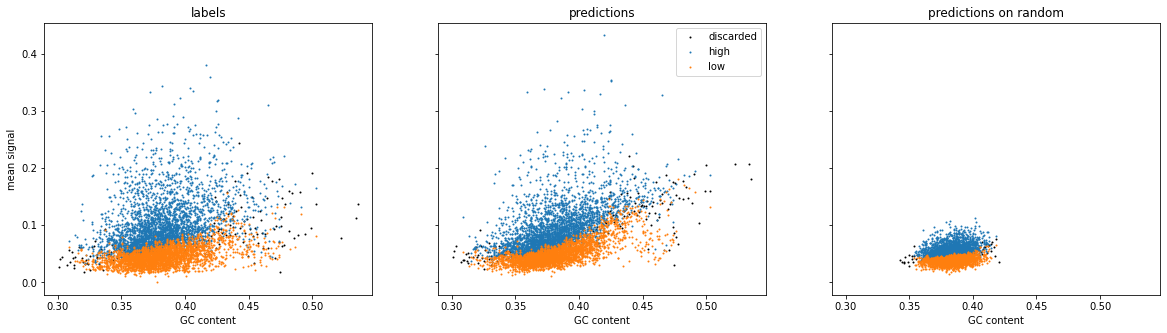

In [274]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True, sharex=True, facecolor='w')
axes[0].set_title('labels')
axes[0].scatter(window_gc_yeast[(~low_label_mask) & (~high_label_mask)], window_labels_annot_yeast[(~low_label_mask) & (~high_label_mask)], s=1, color='k', label='discarded')
axes[0].scatter(window_gc_yeast[high_label_mask], window_labels_annot_yeast[high_label_mask], s=1, label='high')
axes[0].scatter(window_gc_yeast[low_label_mask], window_labels_annot_yeast[low_label_mask], s=1, label='low')
axes[0].set_xlabel('GC content')
axes[0].set_ylabel('mean signal')
# axes[0].set_ylim((0, 0.15))

axes[1].set_title('predictions')
axes[1].scatter(window_gc_yeast[(~low_pred_mask) & (~high_pred_mask)], window_preds_annot_yeast[(~low_pred_mask) & (~high_pred_mask)], s=1, color='k', label='discarded')
axes[1].scatter(window_gc_yeast[high_pred_mask], window_preds_annot_yeast[high_pred_mask], s=1, label='high')
axes[1].scatter(window_gc_yeast[low_pred_mask], window_preds_annot_yeast[low_pred_mask], s=1, label='low')
axes[1].set_xlabel('GC content')
axes[1].legend()

axes[2].set_title('predictions on random')
axes[2].scatter(window_gc_rand[(~low_pred_mask_r) & (~high_pred_mask_r)], window_preds_annot_rand[(~low_pred_mask_r) & (~high_pred_mask_r)], s=1, color='k', label='discarded')
axes[2].scatter(window_gc_rand[high_pred_mask_r], window_preds_annot_rand[high_pred_mask_r], s=1, label='high')
axes[2].scatter(window_gc_rand[low_pred_mask_r], window_preds_annot_rand[low_pred_mask_r], s=1, label='low')
axes[2].set_xlabel('GC content')

plt.show()
plt.close()

In [275]:
df_labels = pd.concat(
    [utils.kmer_counts(window_one_hot_yeast[low_label_mask], k=2, includeN=False),
     utils.kmer_counts(window_one_hot_yeast[high_label_mask], k=2, includeN=False)],
    axis=1).rename(columns={0: 'low', 1: 'high'})
df_labels /= df_labels.sum(axis=0)
df_labels['high-low'] = df_labels.loc[:, 'high'] - df_labels.loc[:, 'low']

df_preds = pd.concat(
    [utils.kmer_counts(window_one_hot_yeast[low_pred_mask], k=2, includeN=False),
     utils.kmer_counts(window_one_hot_yeast[high_pred_mask], k=2, includeN=False)],
    axis=1).rename(columns={0: 'low', 1: 'high'})
df_preds /= df_preds.sum(axis=0)
df_preds['high-low'] = df_preds.loc[:, 'high'] - df_preds.loc[:, 'low']

df_rand = pd.concat(
    [utils.kmer_counts(window_one_hot_rand[low_pred_mask_r], k=2, includeN=False),
     utils.kmer_counts(window_one_hot_rand[high_pred_mask_r], k=2, includeN=False)],
    axis=1).rename(columns={0: 'low', 1: 'high'})
df_rand /= df_rand.sum(axis=0)
df_rand['high-low'] = df_rand.loc[:, 'high'] - df_rand.loc[:, 'low']

df = pd.concat(
    {'diff_labels': df_labels.loc[:, 'high-low'],
     'diff_preds': df_preds.loc[:, 'high-low'],
     'diff_preds_rand': df_rand.loc[:, 'high-low']},
    axis=1)
df

diff_labels  diff_preds  diff_preds_rand
A A     0.001308    0.001444         0.000196
  C     0.000416    0.000052         0.000270
  G    -0.000064   -0.000679        -0.000603
  T    -0.001674   -0.002613        -0.000682
C A    -0.000953   -0.001693        -0.000268
  C    -0.000101    0.000339         0.000229
  G     0.000730    0.000939         0.000557
  T     0.000220    0.000232         0.000020
G A    -0.000973   -0.002038        -0.001256
  C     0.000571    0.000971         0.000406
  G    -0.000127    0.000318        -0.000494
  T     0.000634    0.000937         0.000799
T A     0.000610    0.000495         0.000497
  C    -0.000989   -0.001548        -0.000347
  G    -0.000454   -0.000399        -0.000003
  T     0.000846    0.003243         0.000680

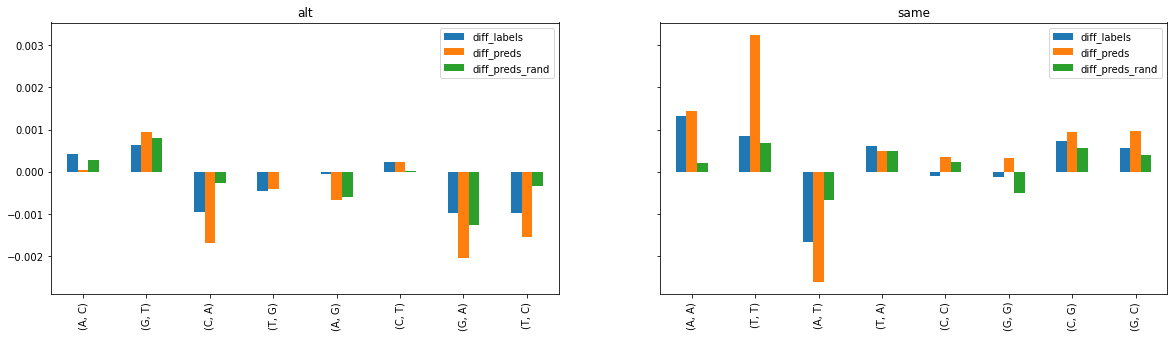

In [278]:
plot_utils.plot_2mer_df(df, group='SW')

Distributions of predictions and labels

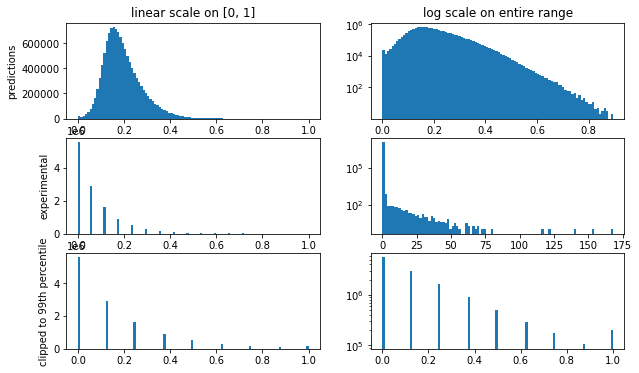

In [123]:
plt.figure(figsize=(10, 6))

plt.subplot(321)
plt.title('linear scale on [0, 1]')
plt.hist(all_preds_yeast, bins=100, range=(0, 1))
plt.ylabel('predictions')

plt.subplot(322)
plt.title('log scale on entire range')
plt.hist(all_preds_yeast, bins=100)
plt.yscale('log')

plt.subplot(323)
plt.hist(norm_yeast, bins=100, range=(0, 1))
plt.ylabel('experimental')

plt.subplot(324)
plt.hist(norm_yeast, bins=100)
plt.yscale('log')

plt.subplot(325)
plt.hist(clip_yeast, bins=100, range=(0, 1))
plt.ylabel('clipped to 99th percentile')

plt.subplot(326)
plt.hist(clip_yeast, bins=100)
plt.yscale('log')

plt.show()
plt.close()

#### Load models

Check model architectures

In [22]:
model = tf.keras.models.load_model(f'{data_dir}/{species}/models_etienne/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
model.summary()
print(model.layers[-1], model.layers[-1].activation)
del model

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 2048, 32)     1568        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 256, 32)      0           conv1d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 32)      128         max_pooling1d_9[0][0]            
_______________________________________________________________________________________

Predict on genomes

In [19]:
species = 'SCerevisiae'
genomes = ['W303', 'Mmm_Linear_740kb', 'Pneu300']
model_files = [
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5'), 'pol'),
    ]
for model_file, annotation_type in model_files:
    for genome in genomes:
        if annotation_type == 'nucleosome':
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
            order_suffix = '_ATGC'
        else:
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
            order_suffix = ''
        if genome == 'W303':
            genome_dir = 'W303'
        else:
            genome_dir = 'bacterie'
        all_preds = {}
        with np.load(Path(data_dir, species, 'genome', genome_dir, f'{genome}{order_suffix}.npz')) as f:
            for chr_id in f.keys():
                one_hot_chr = f[chr_id]
                try:
                    all_preds[chr_id] = predict(one_hot_chr, model, annotation_type)
                except ValueError:
                    print(f"Can't predict on {chr_id}, skipping...")
        del model
        np.savez(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_file.stem}_on_{genome}.npz'), **all_preds)

Can't predict on p2, skipping...


pearsonr: (0.683715419445692, 0.0)
0.07244701428360163 0.07515196


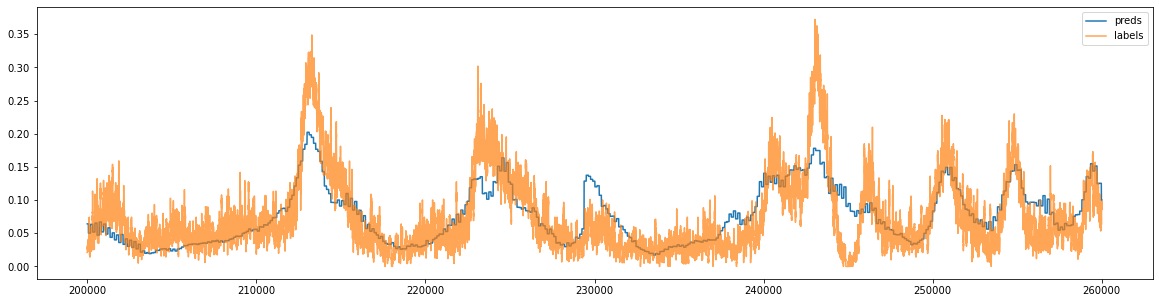

In [57]:
chr_id = 'chr16'
preds = preds_coh[chr_id] / thres_pred_cm
labels = labels_coh[chr_id] # * thres_coh_p
print('pearsonr:', pearsonr(preds, labels))
print(np.mean(preds), np.mean(labels))

start = 200_000
stop = start + 60_000
plt.figure(figsize=(20, 5))
plt.plot(np.arange(start, stop), preds[start:stop], label='preds')#, alpha=0.5, width=1)
plt.plot(np.arange(start, stop), labels[start:stop], label='labels', alpha=0.7)#, width=1)
# plt.plot(np.arange(start, stop), labels_coh_m[chr_id][start:stop], label='labels_m', alpha=0.7)#, width=1)
plt.legend()
plt.savefig('testing_savefig', bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

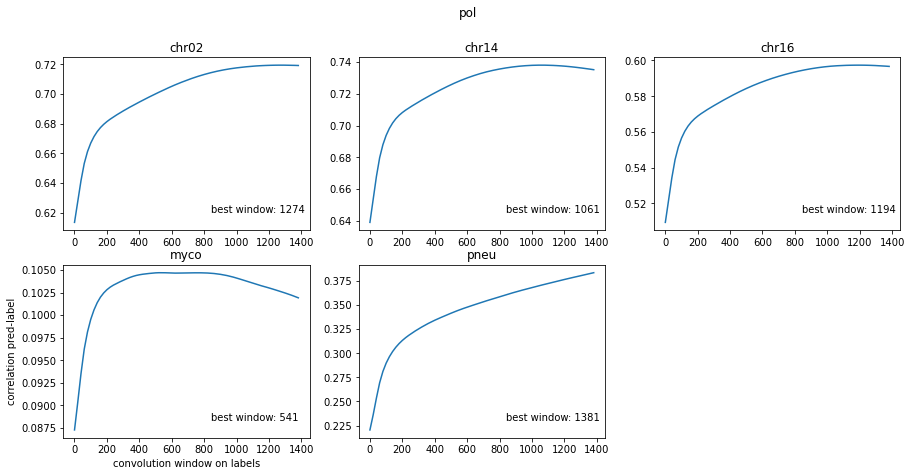

In [168]:
annot = 'pol'
if annot == 'nucleosome':
    preds = preds_nuc
    labels = labels_nuc
    ns = [i for i in range(1, 101)]
elif annot == 'cohesine':
    preds = preds_coh
    labels = labels_coh
    ns = [i for i in range(1, 701, 20)] + [i for i in range(701, 801)] + [i for i in range(801, 1001, 20)]
elif annot == 'pol':
    preds = preds_pol
    labels = labels_pol
    ns = [i for i in range(1, 1101, 20)] + [i for i in range(1101, 1301)] + [i for i in range(1301, 1401, 20)]
plt.figure(figsize=(15, 7))
plt.suptitle(annot)
for i, chr_id in enumerate(['chr02', 'chr14', 'chr16', 'myco', 'pneu']):
    corrs = []
    for n in ns:
        lab = np.convolve(labels[chr_id], np.ones(n), mode='same') / n
        corrs.append(pearsonr(preds[chr_id], lab)[0])
    plt.subplot(231+i)
    plt.plot(ns, corrs)
    plt.title(chr_id)
    if i == 3:
        plt.xlabel('convolution window on labels')
        plt.ylabel('correlation pred-label')
    plt.annotate(f'best window: {ns[np.argmax(corrs)]}', xy=(0.6, 0.1), xycoords="axes fraction")
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', f'corr_{annot}_vs_conv_window.png'), bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

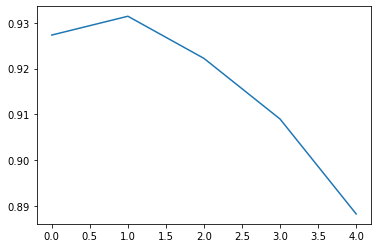

In [8]:
corrs = [pearsonr(pred_nucleosome, pred_nucleosome_rev)[0]]
for offset in range(1, 5):
    corrs.append(pearsonr(pred_nucleosome[offset:], pred_nucleosome_rev[:-offset])[0])
plt.plot(np.arange(len(corrs)), corrs)
plt.show()
plt.close()

Predictions on SynEC for Romain

In [122]:
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100.npz')) as f:
    for k in f.keys():
        one_hot_chr_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr_ATGC = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ATGC = f[k]
        break
one_hot_chr2_ACGT.shape

(125243, 4)

In [169]:
seq = utils.one_hot_decode(one_hot_chr_ACGT)
seq2 = utils.one_hot_decode(one_hot_chr2_ACGT)
ref = utils.one_hot_decode(one_hot_chr_ref_ACGT)

In [225]:
start = 3623
size = 15_045 - start
for i in range(len(ref) - size + 1):
    if seq2[start:start+size] == ref[i:i+size]:
        print(i)

836753


In [262]:
pos = 833_130
start = 65_020
offset = -8625
length = 100
# print(ref[pos+start : pos+start+length])
print(seq[start:start+length])
print(seq2[start+offset:start+offset+length])

CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG
CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG


In [240]:
i = 68852
while seq[-i-1] == seq2[-i-2]:
    i += 1
print(i)

68852


In [132]:
data = 'SCerevisiae'

model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
pred_nucleosome = predict(one_hot_chr_ATGC, model_nucleosome, "nucleosome")
pred_nucleosome2 = predict(one_hot_chr2_ATGC, model_nucleosome, "nucleosome")
del model_nucleosome
# model_nucleosome2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome2 = predict(one_hot_chr_ATGC, model_nucleosome2, "nucleosome")
# del model_nucleosome2
# model_nucleosome3 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome3 = predict(one_hot_chr_ATGC, model_nucleosome3, "nucleosome")
# del model_nucleosome3
# model_nucleosome_pneu = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_pneu_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_pneu = predict(one_hot_chr_ATGC, model_nucleosome_pneu, "nucleosome")
# del model_nucleosome_pneu
# model_nucleosome_all = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_all = predict(one_hot_chr_ATGC, model_nucleosome_all, "nucleosome")
# del model_nucleosome_all

model_cohesine = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate': correlate})
pred_cohesine = predict(one_hot_chr_ACGT, model_cohesine, "cohesine", last_window=True)
pred_cohesine2 = predict(one_hot_chr2_ACGT, model_cohesine, "cohesine", last_window=True)
del model_cohesine

model_pol = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate})
pred_pol = predict(one_hot_chr_ACGT, model_pol, "pol", last_window=True)
pred_pol2 = predict(one_hot_chr2_ACGT, model_pol, "pol", last_window=True)
del model_pol

In [133]:
df = pd.DataFrame({
    'nucleosome': pred_nucleosome,
    'cohesine': pred_cohesine,
    'pol2': pred_pol})
df2 = pd.DataFrame({
    'nucleosome': pred_nucleosome2,
    'cohesine': pred_cohesine2,
    'pol2': pred_pol2})

In [136]:
df.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full.csv')
df2.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC_UAS_TATA-yeGFP-NLS_full.csv')

Testing model loading

In [264]:
preds = {}
for file in Path('..', 'shared_folder', 'SCerevisiae', 'models').glob('*.hdf5'):
    requires_mae_cor = False
    pred = None
    try:
        model = tf.keras.models.load_model(file, custom_objects={'correlate': correlate})
    except:
        model = tf.keras.models.load_model(file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        requires_mae_cor = True
    try:
        pred = predict(one_hot_chr_ref_ACGT, model, "cohesine")
        annotation_type = "cohesine"
    except:
        try:
            pred = predict(one_hot_chr_ref_ACGT, model, "pol")
            annotation_type = "pol"
        except:
            try:
                pred = predict(one_hot_chr_ref_ATGC, model, "nucleosome")
                annotation_type = "nucleosome"
            except:
                annotation_type = None        
    del model
    preds[file] = pred
    print(file, requires_mae_cor, annotation_type)
    # if pred is not None:
    #     start = 54_000
    #     stop = 59_000
    #     fig, ax = plt.subplots(figsize=(15, 3))
    #     ax.plot(np.arange(start, stop), pred[start:stop], linewidth=0.2)
    #     ax.set_ylim(0, 3)
    #     ax.fill_between(np.arange(start, stop), pred[start:stop], 0)
    

../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_3.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_2.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_gal_pol2_2048_16.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_Bassenji_32768_256.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_pneu_rep1_transcription.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_nucleosome_myco_rep3.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_3.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_pneu_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_gal_pol2.hdf5 False cohesine
../shared

Predict

In [192]:
smooth_pred_nucleosome = utils.smooth(pred_nucleosome, 201, mode='gaussian', sigma=10)

In [9]:
pred_nucleosome_etienne = np.load(Path(data_dir, data, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))
pred_nucleosome_etienne.shape # 986200
# preds_etienne[-1010:-990]

(986200,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


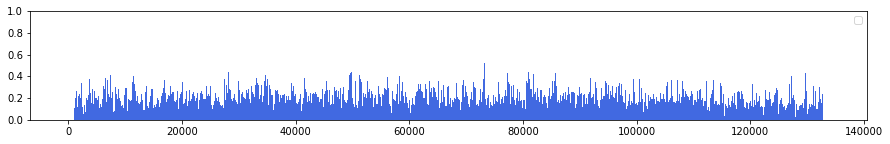

In [48]:
start = 0 #210_000
end = len(df) #220_000
plt.figure(figsize=(15, 4))
# plt.bar(np.arange(start, end), height=pred_nucleosome[start:end], width=1, alpha=1, color=(0, 0, 1), label='pred_myco')
plt.bar(np.arange(start, end), height=df['nucleosome'], width=1, color='royalblue')
# plt.bar(np.arange(start, end), height=pred_nucleosome_etienne[start:end], width=1, alpha=0.3, color=(0, 1, 0), label='pred_etienne')
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.close()

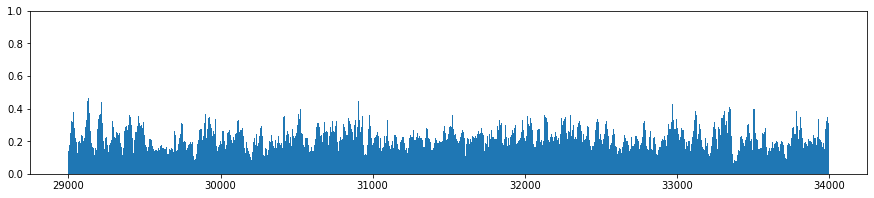

In [181]:
start = 29_000
stop = 34_000
plt.figure(figsize=(15, 3))
plt.bar(np.arange(start, stop), height=df['nucleosome'][start:stop], width=1)
plt.ylim(0, 1)
plt.show()
plt.close()

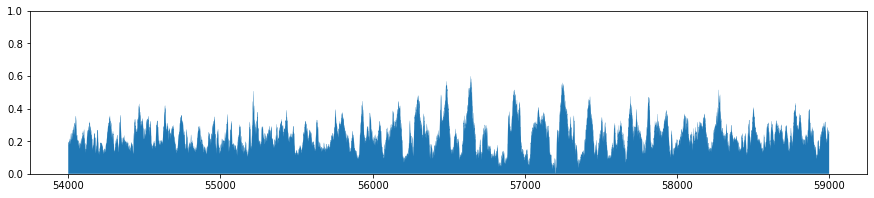

In [185]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC100_nucleosome_zoom', bbox_inches='tight')

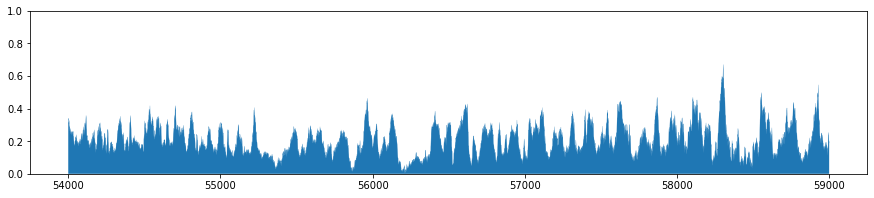

In [186]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df2['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df2['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC_UAS_TATA-yeGFP-NLS_nucleosome_zoom', bbox_inches='tight')

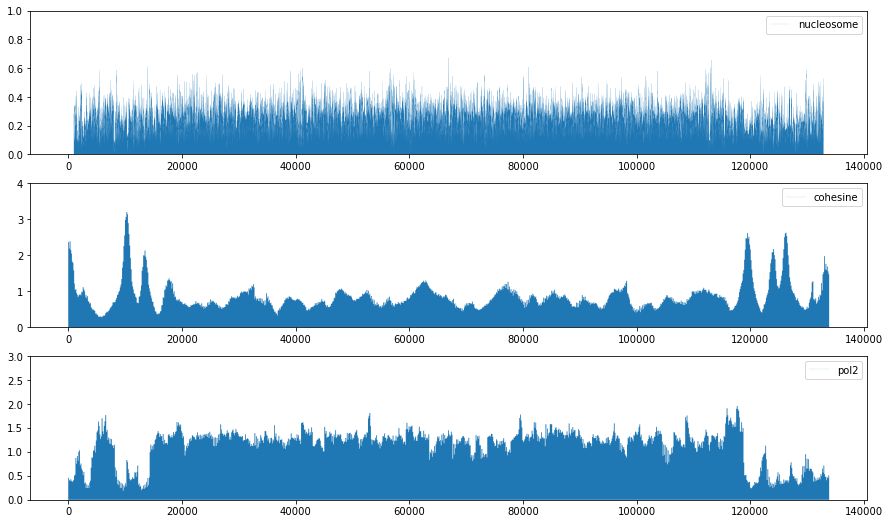

In [135]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 9))
df.plot(y='nucleosome', use_index=True, ylim=(0, 1), ax=axes[0], linewidth=0.1)
axes[0].fill_between(df.index, df['nucleosome'], 0)
df.plot(y='cohesine', use_index=True, ylim=(0, 4), ax=axes[1], linewidth=0.1)
axes[1].fill_between(df.index, df['cohesine'], 0)
df.plot(y='pol2', use_index=True, ylim=(0, 3), ax=axes[2], linewidth=0.1)
axes[2].fill_between(df.index, df['pol2'], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full', bbox_inches='tight')

(0.9999999999998332, 0.0)


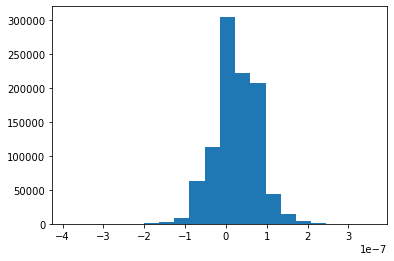

In [20]:
print(pearsonr(pred_nucleosome_pneu, pred_nucleosome_etienne))
diffs = pred_nucleosome_pneu - pred_nucleosome_etienne
plt.hist(diffs, bins=20)
plt.show()
plt.close()

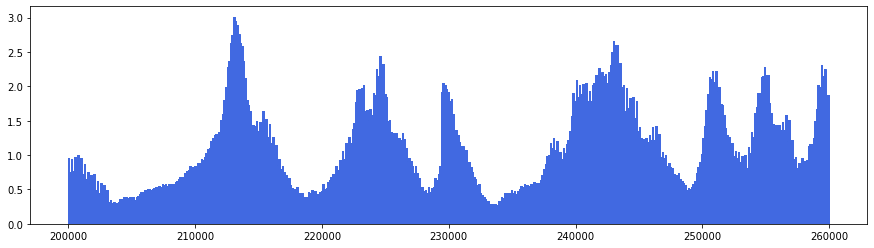

In [35]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_cohesine[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

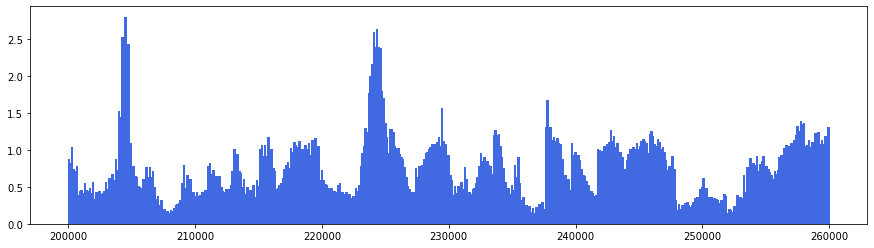

In [32]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_pol[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

## Kinetic Monte Carlo

In [ ]:
# initialisation :
# use ATGC content from SCerevisiae
# build 1000 sequences of length N
# mutation and selection: 
# make every 3*N single nucleotide mutation
# selection probability of 1/norm * exp(-delta_energy / T)
# 10**4 steps
# save each configuration and keep best
# energy :
# create a 2001 + N sequence repeating the length N sequence, centered on it
# distance to target density E_reg is d(x, y) = 1 - corr(x, y) + 1/N * sum(abs(x_i - y_i))
# GC content constraint E_GC is abs(GC_synt - GC_nat) GC_nat=0.38
# E_mut penalizes sequences already seen
# E_rev, like E_reg but on reverse strand
# total energy is exp(-(a*E_GC + b*E_reg + c*E_rev + d*E_mut)/T)